# Plot Audio Files Waveforms and Spectrograms with Essentia

In [6]:
from pathlib import Path
import essentia
import essentia.standard as es

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
# plt.rcParams['axes.grid'] = True
cmap = plt.get_cmap('inferno')

In [7]:
def find_files(directory, pattern):
    for path in Path(directory).rglob('*'):
        if path.is_file() and path.suffix.lower().endswith(pattern):
            yield path


def plot_spectrogram(audio):
    windowing = es.Windowing(type='blackmanharris62', zeroPadding=2048)
    spectrum = es.Spectrum()
    melbands = es.MelBands(numberBands=96, lowFrequencyBound=0, highFrequencyBound=11000)
    spectrum_logfreq = es.LogSpectrum(binsPerSemitone=1)

    amp2db = es.UnaryOperator(type='lin2db', scale=2)
    pool = essentia.Pool()
    
    for frame in es.FrameGenerator(audio, frameSize=2048, hopSize=1024):
        frame_spectrum = spectrum(windowing(frame))
        frame_mel = melbands(frame_spectrum)
        frame_spectrum_logfreq, _, _ = spectrum_logfreq(frame_spectrum)

        pool.add('spectrum_db', amp2db(frame_spectrum))
        pool.add('mel96_db', amp2db(frame_mel))
        pool.add('spectrum_logfreq_db', amp2db(frame_spectrum_logfreq))

    # Plot all spectrograms.
    fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8, 6))

    ax1.set_title("Log-spectrogram (amp2db)")
    ax1.set_xlabel("Time (frames)")
    ax1.set_ylabel("Frequency bins")
    ax1.imshow(pool['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap=cmap)

    ax2.set_title("Mel log-spectrogram (amp2db)")
    ax2.set_xlabel("Time (frames)")
    ax2.set_ylabel("Mel frequency bands")
    ax2.imshow(pool['mel96_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap=cmap)

    ax3.set_title("Log-frequency log-spectrogram (amp2db)")
    ax3.set_xlabel("Time (frames)")
    ax3.set_ylabel("Log-frequency bins")
    ax3.imshow(pool['spectrum_logfreq_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap=cmap)

    plt.tight_layout()
    plt.show()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    # waveform.shape -> [num_channels, num_frames]
    num_channels, num_frames = waveform.shape
    time_axis = np.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(8, 4), sharex=True, sharey=True)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.tight_layout()
    plt.show(block=False)

In [8]:
directory_path = "./audio/"
file_pattern = '.wav'
audio_files = list(find_files(directory_path, file_pattern))

In [9]:
help(es.AudioLoader)

Help on class Algo in module essentia.standard:

class Algo(Algorithm)
 |  Algo(**kwargs)
 |
 |  AudioLoader
 |
 |
 |  Outputs:
 |
 |    [vector_stereosample] audio - the input audio signal
 |                   [real] sampleRate - the sampling rate of the audio signal [Hz]
 |                [integer] numberChannels - the number of channels
 |                 [string] md5 - the MD5 checksum of raw undecoded audio payload
 |                [integer] bit_rate - the bit rate of the input audio, as reported by the decoder codec
 |                 [string] codec - the codec that is used to decode the input audio
 |
 |
 |  Parameters:
 |
 |    audioStream:
 |      integer ∈ [0,inf) (default = 0)
 |      audio stream index to be loaded. Other streams are no taken into account
 |      (e.g. if stream 0 is video and 1 is audio use index 0 to access it.)
 |
 |    computeMD5:
 |      bool ∈ {true,false} (default = false)
 |      compute the MD5 checksum
 |
 |    filename:
 |      string
 |      th

In [10]:
audio_path = str(audio_files[0])
audio, sample_rate, _, _, _, _ = es.AudioLoader(filename=audio_path)()
print(audio_path)
metadata = es.MetadataReader(filename=audio_path)()
print(metadata)
print(f'Input dtype: {audio.dtype}, sample rate: {sample_rate}')
print(f'Input shape: {audio.shape}, min:{audio.min():.6f}, max:{audio.max():.6f}, mean:{audio.mean():.6f}')

audio/IR_AKG_BX25_3500ms_48kHz24b.wav
('', '', '', '', '', '', '', <essentia.common.Pool object at 0x134e69ca0>, 5, 1179, 48000, 1)
Input dtype: float32, sample rate: 48000.0
Input shape: (269190, 2), min:-1.000000, max:0.685696, mean:-0.000001


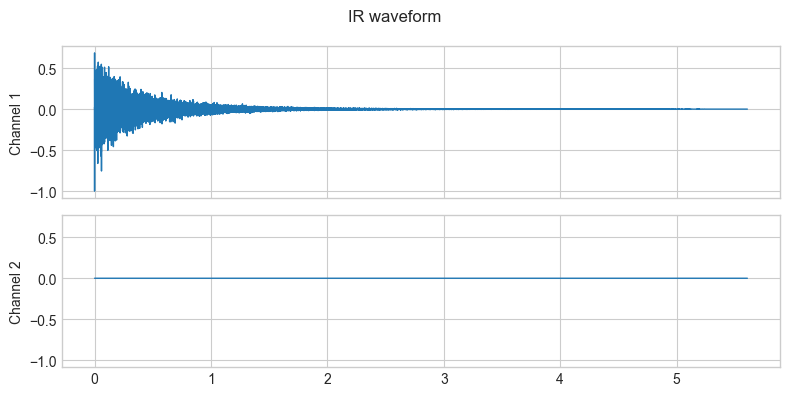

In [11]:
plot_waveform(audio.T, sample_rate, title="IR waveform")

[   INFO   ] TriangularBands: input spectrum size (2049) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] LogSpectrum: input spectrum size does not match '_frameSize' parameter. Reconfiguring the algorithm.


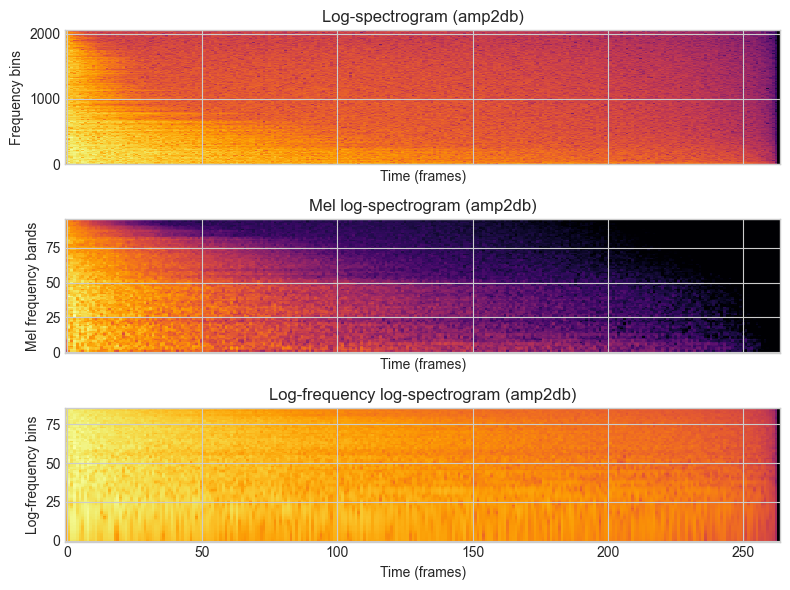

In [12]:
plot_spectrogram(audio[:,0])

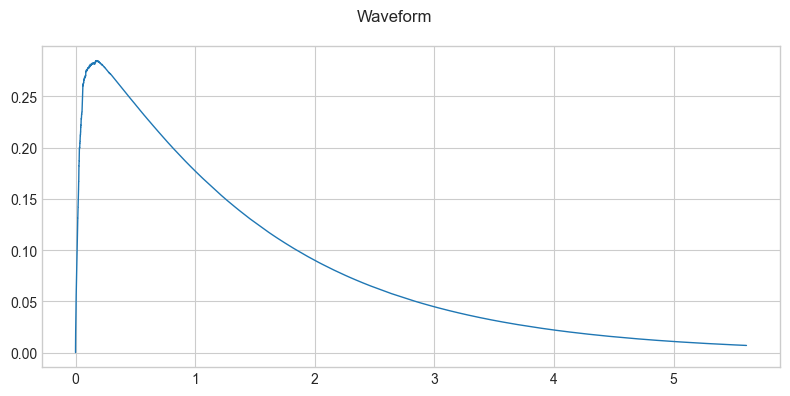

In [13]:
envelope = es.Envelope()
audio_envelope = envelope(audio[:,0])
audio_envelope = audio_envelope.reshape(1, -1)
plot_waveform(audio_envelope, sample_rate)

## Convert Frequency bins to Hz

Frequency of bin $i$:

\begin{equation}
    f(i) = \frac{i * SR} {2 * N (bins)} 
\end{equation}

where $SR$ is the sampling rate and $N$ is the number of bins.

[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] LogSpectrum: input spectrum size does not match '_frameSize' parameter. Reconfiguring the algorithm.


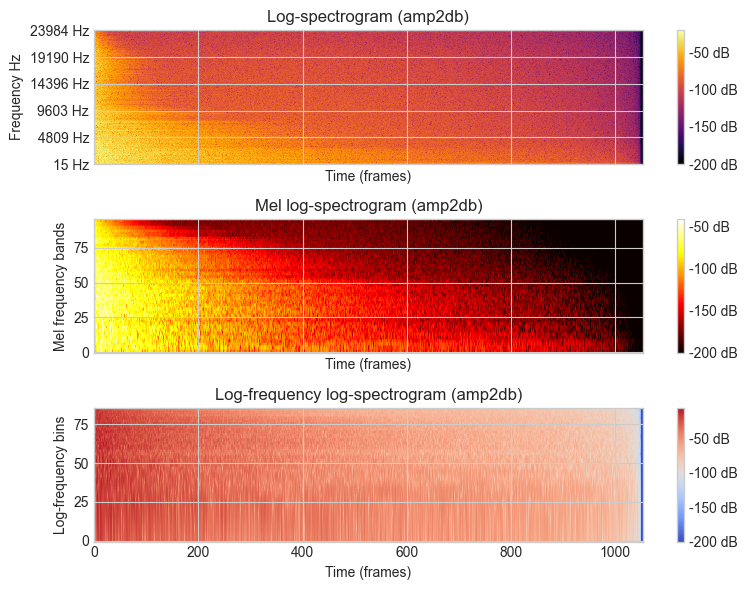

In [14]:
FRAME = int(2 ** 10)

loader = es.MonoLoader(filename=audio_path, sampleRate=sample_rate)
windowing = es.Windowing(type='blackmanharris62', zeroPadding=2048)
spectrum = es.Spectrum()
melbands = es.MelBands(numberBands=96, lowFrequencyBound=0, highFrequencyBound=11000)
spectrum_logfreq = es.LogSpectrum(binsPerSemitone=1)

amp2db = es.UnaryOperator(type='lin2db', scale=2)
pool = essentia.Pool()

audio = loader()

for frame in es.FrameGenerator(audio, frameSize=FRAME, hopSize=256):
    frame_spectrum = spectrum(windowing(frame))
    frame_mel = melbands(frame_spectrum)
    frame_spectrum_logfreq, _, _ = spectrum_logfreq(frame_spectrum)

    pool.add('spectrum_db', amp2db(frame_spectrum))
    pool.add('mel96_db', amp2db(frame_mel))
    pool.add('spectrum_logfreq_db', amp2db(frame_spectrum_logfreq))

num_bins = len(pool['spectrum_db'][0])

y_ticks = np.linspace(1, num_bins-1, 6)  # Creates 6 ticks
y_ticklabels = [f"{int(i * sample_rate / (2.0 * num_bins))} Hz" for i in y_ticks]

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8, 6))

ax1.set_title("Log-spectrogram (amp2db)")
ax1.set_xlabel("Time (frames)")
ax1.set_ylabel("Frequency Hz")
img1 = ax1.imshow(pool['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='inferno')
fig.colorbar(img1, ax=ax1, format="%+2.f dB")
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_ticklabels)

ax2.set_title("Mel log-spectrogram (amp2db)")
ax2.set_xlabel("Time (frames)")
ax2.set_ylabel("Mel frequency bands")
img2 = ax2.imshow(pool['mel96_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='hot')
fig.colorbar(img2, ax=ax2, format="%+2.f dB")

ax3.set_title("Log-frequency log-spectrogram (amp2db)")
ax3.set_xlabel("Time (frames)")
ax3.set_ylabel("Log-frequency bins")
img3 = ax3.imshow(pool['spectrum_logfreq_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='coolwarm')
fig.colorbar(img3, ax=ax3, format="%+2.f dB")

plt.tight_layout()

## Spectrogram Smoothing

In [15]:
def nth_octave_smoothing(spectrum, n: int = 3):
    N = len(spectrum)
    freq_bins = np.linspace(0, int(sample_rate/2), N)
    y = np.zeros(shape=np.shape(spectrum), dtype = type(spectrum[0]))
    M_1 = len(spectrum) - 1

    for k in range(len(spectrum)):
        a = int(np.round(k * 2 ** (-1 /(2 * n))))
        b = int(np.round(k * 2 ** (1 /(2 * n))))

        if a == b:
            b += 1

        if b > M_1:
            b = M_1

        y[k] = (1 / ((b-1) - a + 1)) * np.sum(spectrum[a:b])
    return y, freq_bins

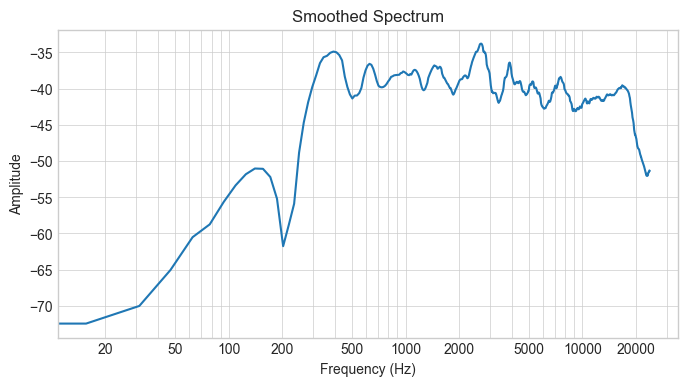

In [16]:

spectrum_smoothed, freq_bins = nth_octave_smoothing(pool['spectrum_db'][0], n=3)

plt.figure(figsize=(8, 4))
plt.semilogx(freq_bins, spectrum_smoothed)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Smoothed Spectrum')

# Set x-ticks at standard frequencies
standard_freqs = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
plt.xticks(standard_freqs, standard_freqs)

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()